change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

pipeline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.models import Model


In [4]:
image_size = (350, 350)
batch_size = 32
img_dir = "/content/drive/MyDrive/colab/datasets/Images"
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

In [5]:
scores_df = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

In [20]:
img_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_ds = img_data_gen.flow_from_dataframe(
    dataframe=scores_df,
    directory=img_dir,
    x_col='file_name',
    y_col='score',
    class_mode='raw',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = img_data_gen.flow_from_dataframe(
    dataframe=scores_df,
    directory=img_dir,
    x_col='file_name',
    y_col='score',
    class_mode='raw',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 4400 validated image filenames.
Found 1100 validated image filenames.


In [19]:
# train_ds = image_dataset_from_directory(
#     directory=img_dir,
#     labels=scores_df['score'].to_numpy().tolist(),
#     label_mode=None,
#     image_size=image_size,
#     batch_size=batch_size,
#     shuffle=True,
#     seed=42,
#     validation_split=0.2,
#     subset='training'
# )

Found 5510 files belonging to 1 classes.
Using 4408 files for training.


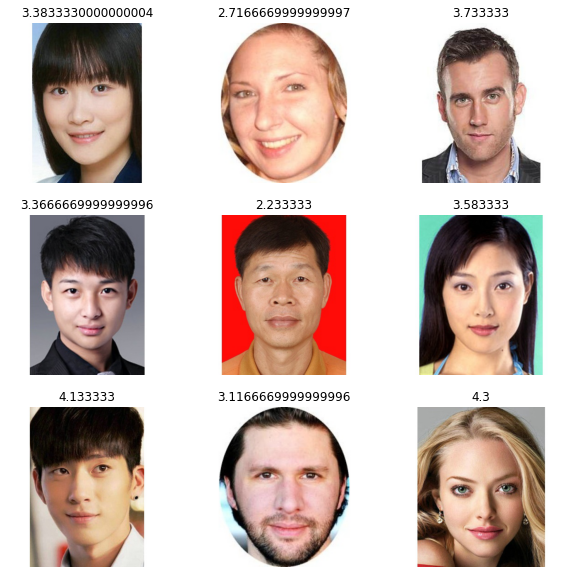

In [21]:
plt.figure(figsize=(10, 10))
images, scores = train_ds[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

In [22]:
def identity_block(X, f, filters, training=True, initializer=he_normal):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [23]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=he_normal):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [24]:
def ResNet50(input_shape=(64, 64, 3)):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2)(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])
    X = identity_block(X, f=3, filters=[128, 128, 512])

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])
    X = identity_block(X, f=3, filters=[256, 256, 1024])

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, f=3, filters=[512, 512, 2048])
    X = identity_block(X, f=3, filters=[512, 512, 2048])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=0))(X)
    X = Dense(1)(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

In [25]:
model = ResNet50(input_shape=(350, 350, 3))

model.compile(
    optimizer='adam',
    loss='mean_absolute_error'
)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds.map(num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# # val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds)

Epoch 1/10
138/138 [==============================] - 1233s 9s/step - loss: 1.1384 - val_loss: 0.7383
Epoch 2/10
138/138 [==============================] - 243s 2s/step - loss: 0.7164 - val_loss: 0.6879
Epoch 3/10
138/138 [==============================] - 243s 2s/step - loss: 0.6603 - val_loss: 0.7451
Epoch 4/10
138/138 [==============================] - 243s 2s/step - loss: 0.6862 - val_loss: 0.6043
Epoch 5/10
138/138 [==============================] - 244s 2s/step - loss: 0.6274 - val_loss: 0.8827
Epoch 6/10
138/138 [==============================] - 243s 2s/step - loss: 0.6284 - val_loss: 0.9427
Epoch 7/10
138/138 [==============================] - 243s 2s/step - loss: 0.6143 - val_loss: 0.6570
Epoch 8/10
138/138 [==============================] - 243s 2s/step - loss: 0.5565 - val_loss: 0.5413
Epoch 9/10
138/138 [==============================] - 244s 2s/step - loss: 0.5120 - val_loss: 0.6094
Epoch 10/10
138/138 [==============================] - 243s 2s/step - loss: 0.6120 - val_l